In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', periods=300, freq='D')

#trend component
trend = np.linspace(10, 20, 300)

#seasonality component
seasonality = 3 * np.sin(2 * np.pi * date_range.dayofyear / 7)

#random gaussian noise
noise = np.random.normal(loc=0, scale=1, size=300)

#time series = noise + seasonality + trend
data = trend + seasonality + noise
ts = pd.Series(data, index=date_range)


train = ts[:270]
test = ts[270:]

# 1. Forecast Methods

## 1.1. ARIMA Model

The ARIMA model is like the ARMA model, but it does differencing (taking differences) inside automatically. When making predictions, it converts the results back to the original scale. These two approaches are basically the same:

* First diff dataset -> $ARMA(p,q)$ -> pred -> convert preds back
* Dataset -> $ARIMA(p,1,q)$ -> pred


The model below is equivalent to $AR(5)$ model.

In [3]:
p = 5
d = 1
q = 0

arima_model = ARIMA(train, order=(p,d,q)).fit()
arima_train_preds = arima_model.fittedvalues
arima_test_preds = arima_model.forecast(len(test))

mae = mean_absolute_error(train[p:], arima_train_preds[p:])
mse = mean_squared_error(train[p:], arima_train_preds[p:])
print("Train MAE:", mae)
print("Train MSE:", mse)
print()

mae = mean_absolute_error(test, arima_test_preds)
mse = mean_squared_error(test, arima_test_preds)
print("Validation MAE:", mae)
print("Validation MSE:", mse)

Train MAE: 1.0152721913938783
Train MSE: 1.6432576436480077

Validation MAE: 1.3521632584905492
Validation MSE: 2.661139295890028


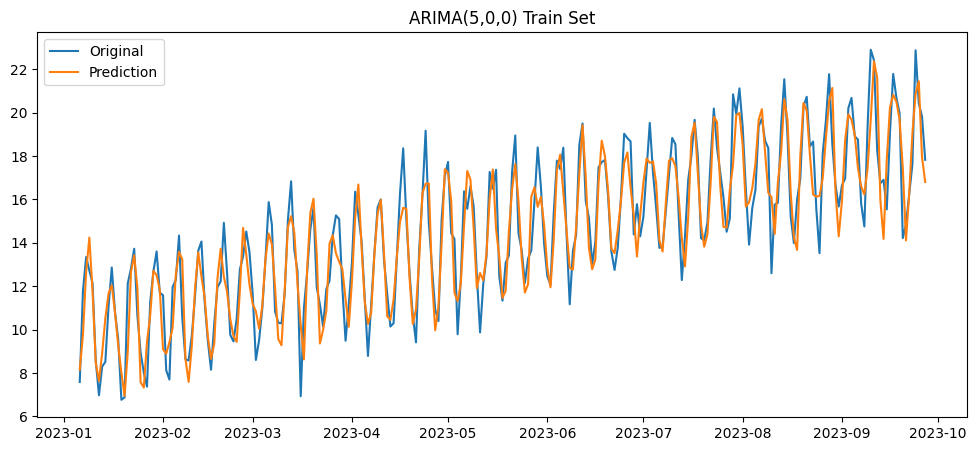

In [4]:
plt.figure(figsize=(12,5))
plt.plot(train[p:], label='Original')
plt.plot(arima_train_preds[p:], label='Prediction')
plt.legend()
plt.title('ARIMA(5,0,0) Train Set')
plt.show()

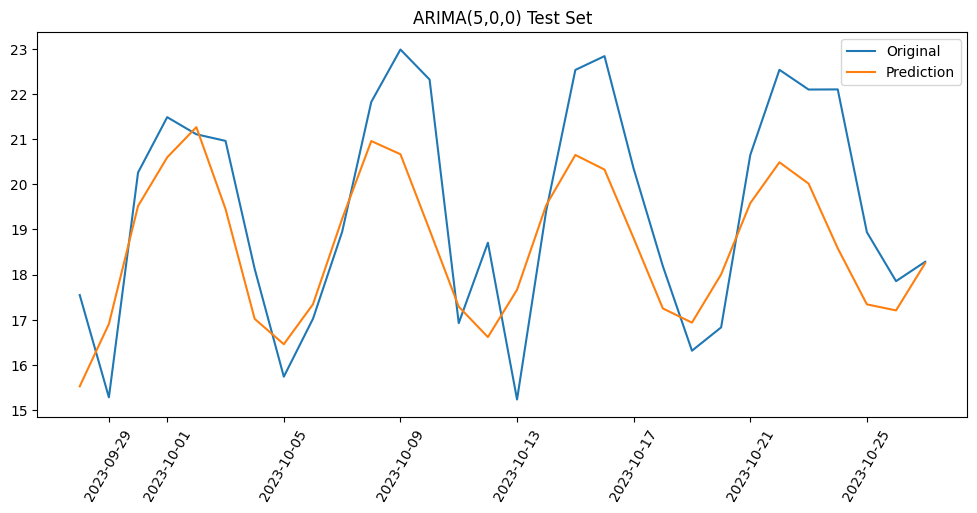

In [5]:
plt.figure(figsize=(12,5))
plt.plot(test, label='Original')
plt.plot(arima_test_preds, label='Prediction')
plt.legend()
plt.title('ARIMA(5,0,0) Test Set')
plt.xticks(rotation = 60)
plt.show()

In [6]:
rolling_arima_preds = []
history = list(train)
for i in tqdm(range(len(test))):
  model = ARIMA(history, order=(1,0,0)).fit()
  pred = model.forecast(steps=1)[0]
  rolling_arima_preds.append(pred)
  history.append(test[i])

rolling_arima_preds = pd.Series(rolling_arima_preds, index=test.index)
mae = mean_absolute_error(test, rolling_arima_preds)
mse = mean_squared_error(test, rolling_arima_preds)
print("Validation MAE:", mae)
print("Validation MSE:", mse)

100%|██████████| 30/30 [00:05<00:00,  5.12it/s]

Validation MAE: 2.076402238416867
Validation MSE: 5.921020847998794


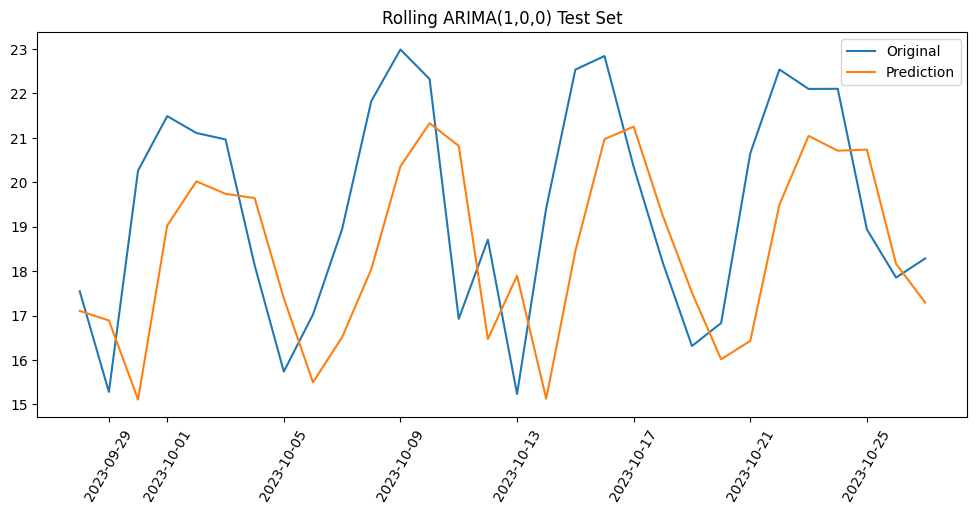

In [7]:
plt.figure(figsize=(12,5))
plt.plot(test, label='Original')
plt.plot(rolling_arima_preds, label='Prediction')
plt.legend()
plt.title('Rolling ARIMA(1,0,0) Test Set')
plt.xticks(rotation = 60)
plt.show()

## 1.2. SARIMA Model

Incorperates seasonality. Since synthetic data cycles in every 7 days 4'th component of seasonal order is 7. For automatic parameter selection, `pmdarima` (compatible with `numpy<2`) can be used.

In [8]:
model_order = (5,1,0)
seasonal_order = (5,1,0,7)
sarima_model = SARIMAX(train, order=model_order, seasonal_order=seasonal_order).fit()
sarima_train_preds = sarima_model.fittedvalues

mae = mean_absolute_error(train[5:], sarima_train_preds[5:])
mse = mean_squared_error(train[5:], sarima_train_preds[5:])
print("Train MAE:", mae)
print("Train MSE:", mse)
print()

Train MAE: 0.9214609538381852
Train MSE: 1.4425340962114672



In [9]:
sarima_test_preds = sarima_model.forecast(len(test))
mae = mean_absolute_error(test, sarima_test_preds)
mse = mean_squared_error(test, sarima_test_preds)
print("Validation MAE:", mae)
print("Validation MSE:", mse)

Validation MAE: 0.8522791855478921
Validation MSE: 1.1338294606434869


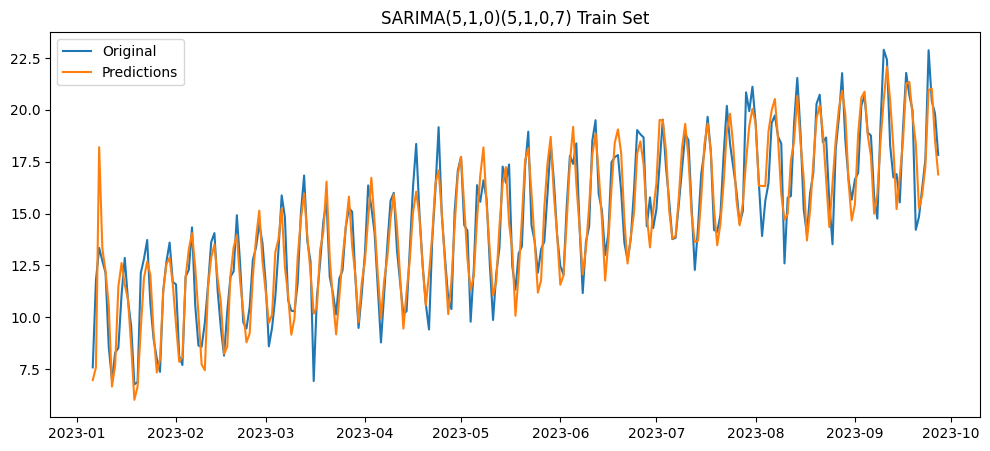

In [10]:
plt.figure(figsize = (12,5))
plt.plot(train[5:],label = "Original")
plt.plot(sarima_train_preds[5:],label = "Predictions")
plt.legend()
plt.title('SARIMA(5,1,0)(5,1,0,7) Train Set')
plt.show()

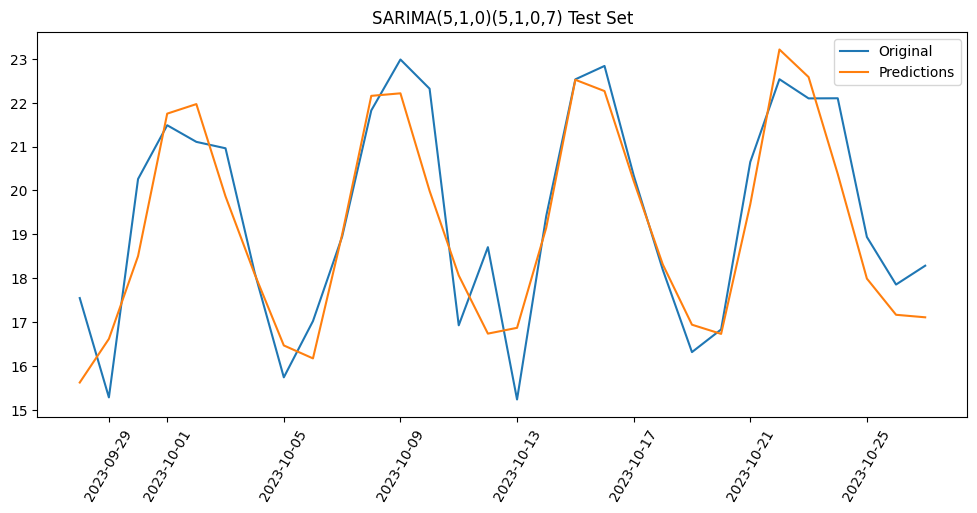

In [11]:
plt.figure(figsize = (12,5))
plt.plot(test,label = "Original")
plt.plot(sarima_test_preds,label = "Predictions")
plt.legend()
plt.title('SARIMA(5,1,0)(5,1,0,7) Test Set')
plt.xticks(rotation = 60)
plt.show()

### 1.2.1. Improving Model Predictions Using Rolling Window Origin

In [12]:
sarima_test_preds = []
history = list(train)

for i in tqdm(range(len(test))):
  model = SARIMAX(history, order=model_order, seasonal_order=seasonal_order).fit()
  pred = model.forecast(steps=1)[0]
  sarima_test_preds.append(pred)
  history.append(test[i])

sarima_test_preds = pd.Series(sarima_test_preds, index=test.index)
mae = mean_absolute_error(test, sarima_test_preds)
mse = mean_squared_error(test, sarima_test_preds)
print("Validation MAE:", mae)
print("Validation MSE:", mse)

100%|██████████| 30/30 [01:17<00:00,  2.60s/it]

Validation MAE: 0.9020541768648012
Validation MSE: 1.166939935899787


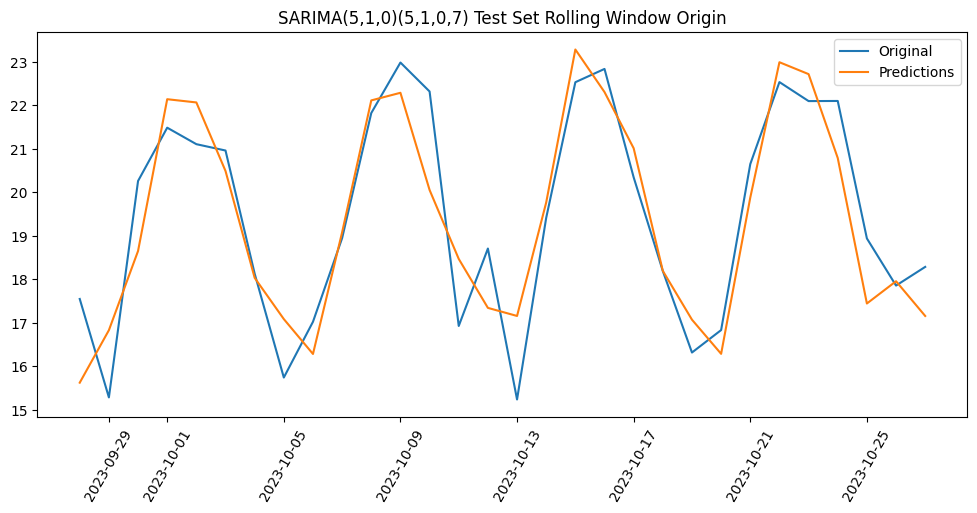

In [13]:
plt.figure(figsize = (12,5))
plt.plot(test,label = "Original")
plt.plot(sarima_test_preds,label = "Predictions")
plt.legend()
plt.title('SARIMA(5,1,0)(5,1,0,7) Test Set Rolling Window Origin')
plt.xticks(rotation = 60)
plt.show()

## 1.3. Simple Exponential Smoothing

$f_t = \alpha y_{t-1} + (1-α)f_{t-1}$

where $\alpha$ is the smoothing constant.

* The model assigns decreasing weights to older parameters.

* It is sutiable for time series having no seasonality or trend.

* The forecast will be a flat line.

In [14]:
ALPHA = 0.3

first_diff = train.diff(1).dropna()
test_first_diff = test.diff(1).dropna()

simple_smoothing_model = SimpleExpSmoothing(first_diff).fit(smoothing_level=ALPHA,
                                                    optimized=False)

simple_smoothing_preds = simple_smoothing_model.fittedvalues
mae = mean_absolute_error(first_diff, simple_smoothing_preds)
mse = mean_squared_error(first_diff, simple_smoothing_preds)
print("Train MAE:", mae)
print("Train MSE:", mse)

simple_smoothing_test_preds = simple_smoothing_model.forecast(len(test_first_diff))
mae = mean_absolute_error(test_first_diff, simple_smoothing_test_preds)
mse = mean_squared_error(test_first_diff, simple_smoothing_test_preds)
print("Validation MAE:", mae)
print("Validation MSE:", mse)

Train MAE: 2.1397728092374058
Train MSE: 6.89465642117802
Validation MAE: 2.0595875764749207
Validation MSE: 6.354768612939528


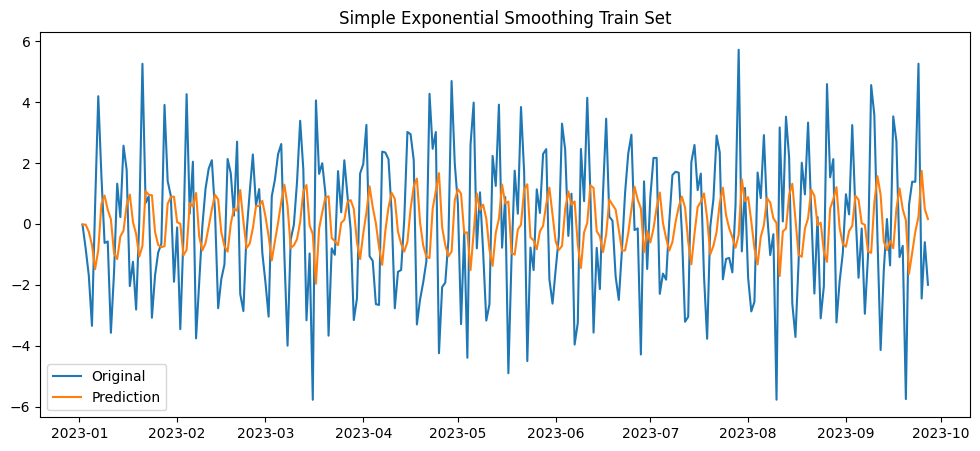

In [15]:
plt.figure(figsize=(12,5))
plt.plot(first_diff, label='Original')
plt.plot(simple_smoothing_preds, label='Prediction')
plt.legend()
plt.title('Simple Exponential Smoothing Train Set')
plt.show()

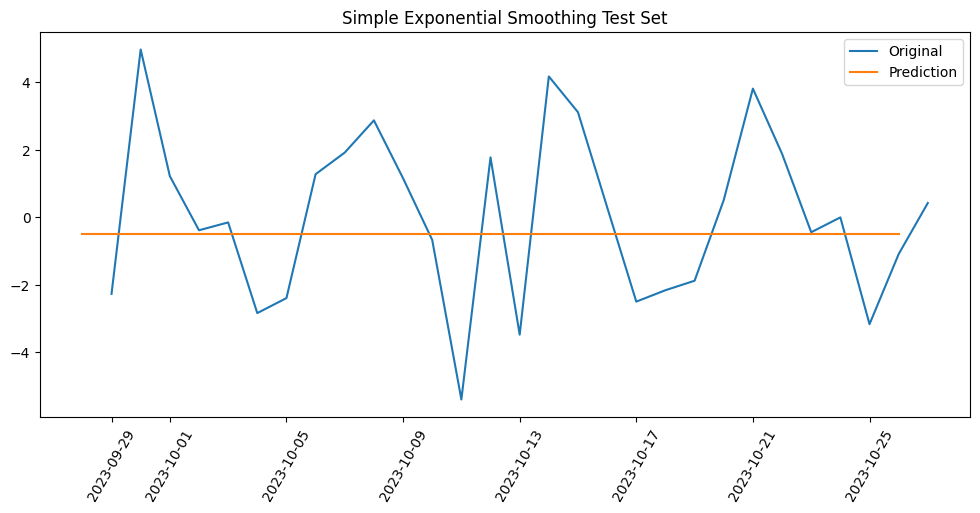

In [16]:
plt.figure(figsize=(12,5))
plt.plot(test_first_diff, label='Original')
plt.plot(simple_smoothing_test_preds, label='Prediction')
plt.legend()
plt.title('Simple Exponential Smoothing Test Set')
plt.xticks(rotation = 60)
plt.show()

### 1.3.1. Rolling Window Origin for Simple Exponential Smoothing

In [17]:
history = list(first_diff)
simple_smoothing_test_preds = []
for i in tqdm(range(len(test_first_diff))):
  model = SimpleExpSmoothing(history).fit(smoothing_level=ALPHA,
                                          optimized=False)
  pred = model.forecast(steps=1)[0]
  simple_smoothing_test_preds.append(pred)
  history.append(test_first_diff[i])

simple_smoothing_test_preds = pd.Series(simple_smoothing_test_preds, index=test_first_diff.index)

mae = mean_absolute_error(test_first_diff, simple_smoothing_test_preds)
mse = mean_squared_error(test_first_diff, simple_smoothing_test_preds)
print()
print("Validation MAE:", mae)
print("Validation MSE:", mse)

100%|██████████| 29/29 [00:00<00:00, 423.31it/s]


Validation MAE: 2.300004678645098
Validation MSE: 7.796238925408185


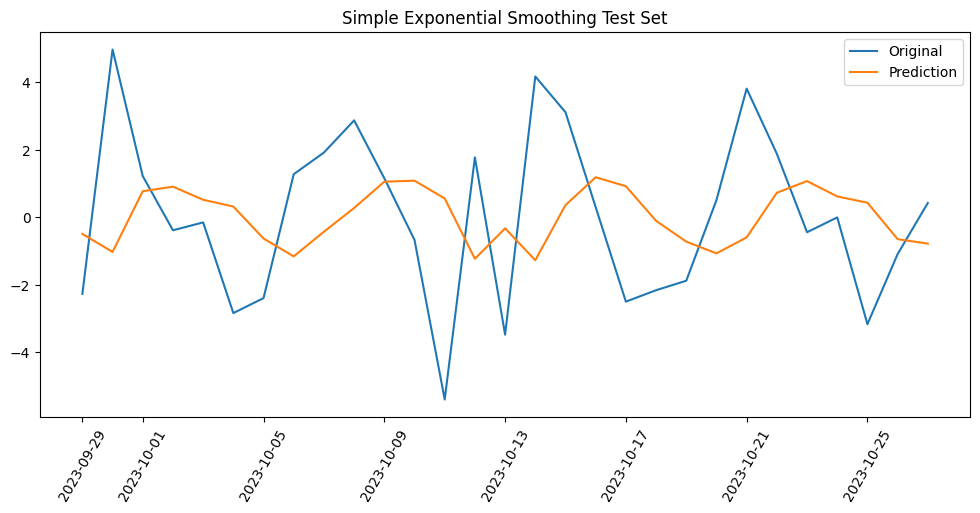

In [18]:
plt.figure(figsize=(12,5))
plt.plot(test_first_diff, label='Original')
plt.plot(simple_smoothing_test_preds, label='Prediction')
plt.legend()
plt.title('Simple Exponential Smoothing Test Set')
plt.xticks(rotation = 60)
plt.show()

### 1.4. Double Exponential Smoothing

Forecase equation: $f_{t+h} = l_t + h ⋅b_t$

Level equation: $l_t = \alpha \cdot y_t + (1-α) ⋅ (l_{t-1}+b_{t-1})$

Trend equation: $b_t = β ⋅ (l_t -l_{t-1}) + (1-β)⋅b_{t-1}$

where

$l_t$: Level

$b_t$: Trend prediction

$y_t$: Real observed value

$\alpha$: Smoothing constant

$β$: Trend constant


* The model has two smoothing equations: One for trend one for level.

* It estimates level and trend separately then combines them.

* The forecast is not a flat line because it uses trend for the predictions.

In [19]:
double_smoothing_model = ExponentialSmoothing(train, trend='add',
                                              seasonal='add',
                                              seasonal_periods=7).fit()

double_smoothing_train_preds = double_smoothing_model.fittedvalues
double_smoothing_preds = double_smoothing_model.forecast(len(test))

mae = mean_absolute_error(train, double_smoothing_train_preds)
mse = mean_squared_error(train, double_smoothing_train_preds)
print("Train MAE:", mae)
print("Train MSE:", mse)
print()

mae = mean_absolute_error(test, double_smoothing_preds)
mse = mean_squared_error(test, double_smoothing_preds)
print("Validation MAE:", mae)
print("Validation MSE:", mse)

Train MAE: 0.7743940591010189
Train MSE: 0.9582341598967044

Validation MAE: 0.7564197713523826
Validation MSE: 0.9389453345320139


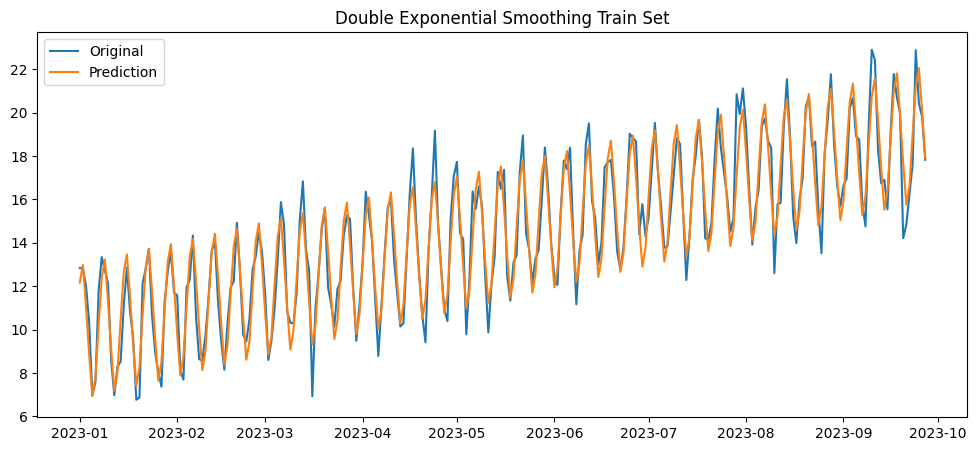

In [20]:
plt.figure(figsize=(12,5))
plt.plot(train, label='Original')
plt.plot(double_smoothing_train_preds, label='Prediction')
plt.legend()
plt.title('Double Exponential Smoothing Train Set')
plt.show()

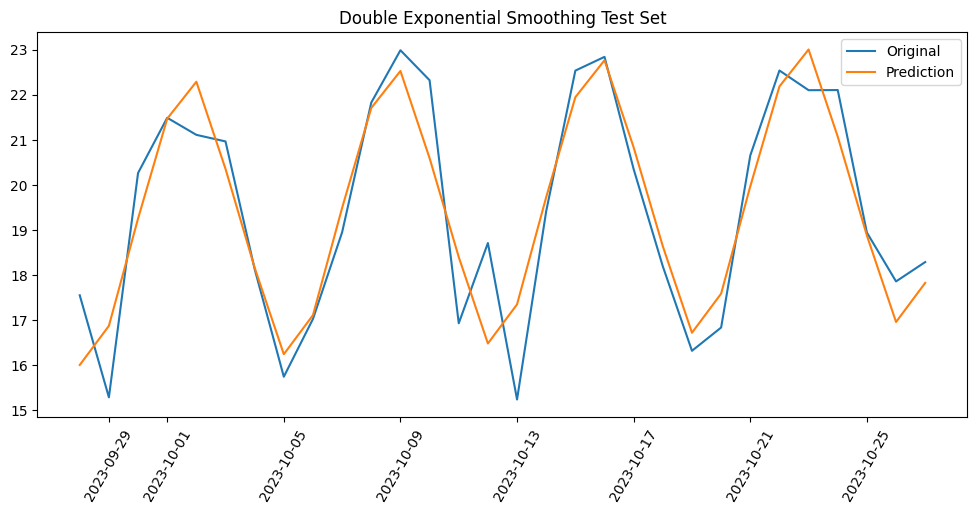

In [21]:
plt.figure(figsize=(12,5))
plt.plot(test, label='Original')
plt.plot(double_smoothing_preds, label='Prediction')
plt.legend()
plt.title('Double Exponential Smoothing Test Set')
plt.xticks(rotation = 60)
plt.show()